In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import wilcoxon

from world_machine_experiments.shared.save_metrics import load_multiple_metrics, get_values
from world_machine_experiments.toy1d.dimensions import Dimensions
from world_machine.train.stages import StateSaveMethod

In [2]:
metrics = load_multiple_metrics("toy1d_experiment1_configuration_test", "toy1d_metrics")
parameters = load_multiple_metrics("toy1d_experiment1_configuration_test", "parameters")
train_history = load_multiple_metrics("toy1d_experiment1_configuration_test", "toy1d_train_history")

In [3]:
list(metrics.keys()) == list(parameters.keys()), list(train_history.keys()) == list(metrics.keys())

(True, True)

In [4]:
names = np.array(list(metrics.keys()))
metric_names = ["normal", "use_state", "prediction", "prediction_shallow"]

In [5]:
parameters_data = []

for name in parameters:
    item = parameters[name]["parameters"]
    item["name"] = name
    item["diverge"] = name not in names

    for m in metric_names:
        for criterion in ["mse", "0.1sdtw"]:
            item[f"{m}_{criterion}"] = metrics[name]["means"][m][f"state_decoded_{criterion}"]
    
    parameters_data.append(item)

In [6]:
df = pd.DataFrame(parameters_data)

In [72]:
mask = np.ones(len(df), bool)
for metric in metric_names:
    mask = np.bitwise_and(mask, np.bitwise_not(df[metric+"_mse"].isna()))

    data = df[f"{metric}_mse"].to_numpy()

    data_mask = np.bitwise_not(np.isnan(data))
    data_mask = np.bitwise_and(data_mask, data<1)
    
    data_max = data[data_mask].mean() + 3*data[data_mask].std()
    
    mask = np.bitwise_and(mask, np.bitwise_not(np.isnan(data)))
    mask = np.bitwise_and(mask, data<data_max)

mask.sum()

3070

In [73]:
df["mask"] = mask

In [7]:
df["SB_1"] = np.bitwise_and(df["n_segment"] == 2, df["fast_forward"] == False)
df["SB_2"] = np.bitwise_and(df["n_segment"] == 2, df["fast_forward"] == True)

df["SM_1"] = df["state_save_method"] == StateSaveMethod.MEAN.value
df["SM_2"] = df["check_input_masks"] == True

df["AC_1"] = pd.isnull(df["state_activation"])

df["MD_1"] = df["block_configuration"].map(lambda x : np.alltrue(x == [Dimensions.MEASUREMENT.value, Dimensions.STATE_INPUT.value]))

df["NA_1"] = df["noise_config"].map(lambda x: x is not None and "state" in x)
df["NA_2"] = df["noise_config"].map(lambda x: x is not None and "measurement" in x)

#df["ST_1"] = df["recall_stride_past"] == 1
#df["ST_2"] = df["recall_stride_past"] == 3
#df["ST_3"] = df["recall_n_past"] == 1
#df["ST_4"] = df["recall_n_past"] == 5
#df["ST_5"] = df["recall_n_future"] == 1
#df["ST_6"] = df["recall_n_future"] == 5

df["ST_1"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_past"] == 1)
df["ST_2"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_past"] == 5)
df["ST_3"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_past"] == 1)
df["ST_4"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_past"] == 5)

df["ST_5"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_future"] == 1)
df["ST_6"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_future"] == 5)
df["ST_7"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_future"] == 1)
df["ST_8"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_future"] == 5)


In [8]:
variables = ["SB_1", "SB_2", "SM_1", "SM_2", "AC_1", "MD_1", "NA_1", "NA_2", "ST_1", "ST_2", "ST_3", "ST_4", "ST_5", "ST_6", "ST_7", "ST_8"]

In [9]:
disjunt_groups = [{"ST_1", "ST_2", "ST_3", "ST_4"}, 
                  {"ST_5", "ST_6", "ST_7", "ST_8"}, 
                  {"ST_1", "ST_2", "ST_7", "ST_8"},
                  {"ST_3", "ST_4", "ST_5", "ST_6"},
                  {"SB_1", "SB_2"},
                  ]

In [80]:
def impact_test(df, variable, metric):
    x : pd.DataFrame = df[df[variable] == False]
    y : pd.DataFrame  = df[df[variable] == True]

    disjunt_vars = set()
    for group in disjunt_groups:
        if variable in group:
            disjunt_vars.update(group)

    for var in disjunt_vars:
        x = x[x[var]==False]

    for var in variables:
        if var == variable or var in disjunt_vars:
            continue
    
        x = x.sort_values(by=var, kind="stable")
        y = y.sort_values(by=var, kind="stable")

    x_mask = x["mask"].to_numpy()
    y_mask = y["mask"].to_numpy()
    mask = np.bitwise_and(x_mask, y_mask)
    
    x : np.ndarray = x[metric].to_numpy()
    y : np.ndarray = y[metric].to_numpy()
    
    x = x[mask]
    y = y[mask]
    
    result = wilcoxon(x, y, nan_policy="omit")
    
    diff = (y - x)
    diff = diff[np.bitwise_not(np.isnan(diff))].mean()

    return result.pvalue, diff

In [81]:
for var in variables:
    print(var, impact_test(df, var, "normal_mse"))

SB_1 (1.6322276173166025e-90, 0.00162409713846587)
SB_2 (7.244093715045175e-89, 0.0014109840825375906)
SM_1 (1.574768317862715e-162, 0.0017312935577747633)
SM_2 (0.042457682177801916, -1.3750843282824279e-05)
AC_1 (8.044085479674172e-197, 0.003176729456147228)
MD_1 (0.021477334721990093, 3.330923219385943e-05)
NA_1 (7.150145579826518e-09, 0.0007136390345363782)
NA_2 (9.48279439298511e-103, 0.0010083909631027161)
ST_1 (0.035544432676239184, -4.639639249467021e-05)
ST_2 (4.4896687560605154e-20, -0.0005738247159080437)
ST_3 (0.8176999622873098, 2.6971850668879474e-05)
ST_4 (5.471139670470592e-16, -0.0006349036445638883)
ST_5 (0.6190798653728014, 4.571956808520321e-05)
ST_6 (6.357150907398789e-08, 0.00041122423894413484)
ST_7 (0.31501628216264377, -6.359255743660104e-05)
ST_8 (3.630124925922824e-15, 0.0005967771279584163)


In [82]:
for var in variables:
    print(var, impact_test(df, var, "prediction_shallow_mse"))

SB_1 (2.1376623382221707e-13, -0.008923516387031191)
SB_2 (3.0046358892078707e-33, -0.014983032781524528)
SM_1 (9.204662233555523e-58, 0.016640132879091503)
SM_2 (0.16602572656835612, -0.0016961284082619844)
AC_1 (1.8470533153043198e-98, 0.034046107672559035)
MD_1 (0.4475184879644365, 0.000812707909684827)
NA_1 (2.4265521489317532e-43, 0.020015150015724115)
NA_2 (2.5406380206055116e-15, -0.007639810508368788)
ST_1 (0.0024278216276788175, 0.004862159994002935)
ST_2 (3.2627335007555966e-11, 0.011694569398577397)
ST_3 (1.751760380401813e-05, 0.00560291604263576)
ST_4 (0.0012217880350424751, 0.0038294869750626526)
ST_5 (0.4848982241248233, 0.0022318843702285283)
ST_6 (0.002453351374721314, 0.006159987793474346)
ST_7 (0.1649946551879906, 0.0025408732681844446)
ST_8 (0.21710726541980896, 0.004169276838030529)


In [87]:
test_data = []

for var in variables:

    for task in ["normal", "prediction_shallow"]:

        p_value, impact = impact_test(df, var, f"{task}_mse")

        item = {"variable":var, "task":task}
        item["p_value"] = p_value
        item["impact"] = impact

        test_data.append(item)
df_test = pd.DataFrame(test_data)

In [93]:
df_test[df_test["p_value"]>=0.05]

,variable,task,p_value,impact
7,SM_2,prediction_shallow,0.166026,-0.001696
11,MD_1,prediction_shallow,0.447518,0.000813
20,ST_3,normal,0.817700,0.000027
24,ST_5,normal,0.619080,0.000046
25,ST_5,prediction_shallow,0.484898,0.002232
28,ST_7,normal,0.315016,-0.000064
29,ST_7,prediction_shallow,0.164995,0.002541
31,ST_8,prediction_shallow,0.217107,0.004169


In [88]:
import seaborn as sns

In [137]:
failed = df_test[df_test["p_value"]>=0.05]

In [138]:
failed

,variable,task,p_value,impact
7,SM_2,prediction_shallow,0.166026,-0.001696
11,MD_1,prediction_shallow,0.447518,0.000813
20,ST_3,normal,0.817700,0.000027
24,ST_5,normal,0.619080,0.000046
25,ST_5,prediction_shallow,0.484898,0.002232
28,ST_7,normal,0.315016,-0.000064
29,ST_7,prediction_shallow,0.164995,0.002541
31,ST_8,prediction_shallow,0.217107,0.004169


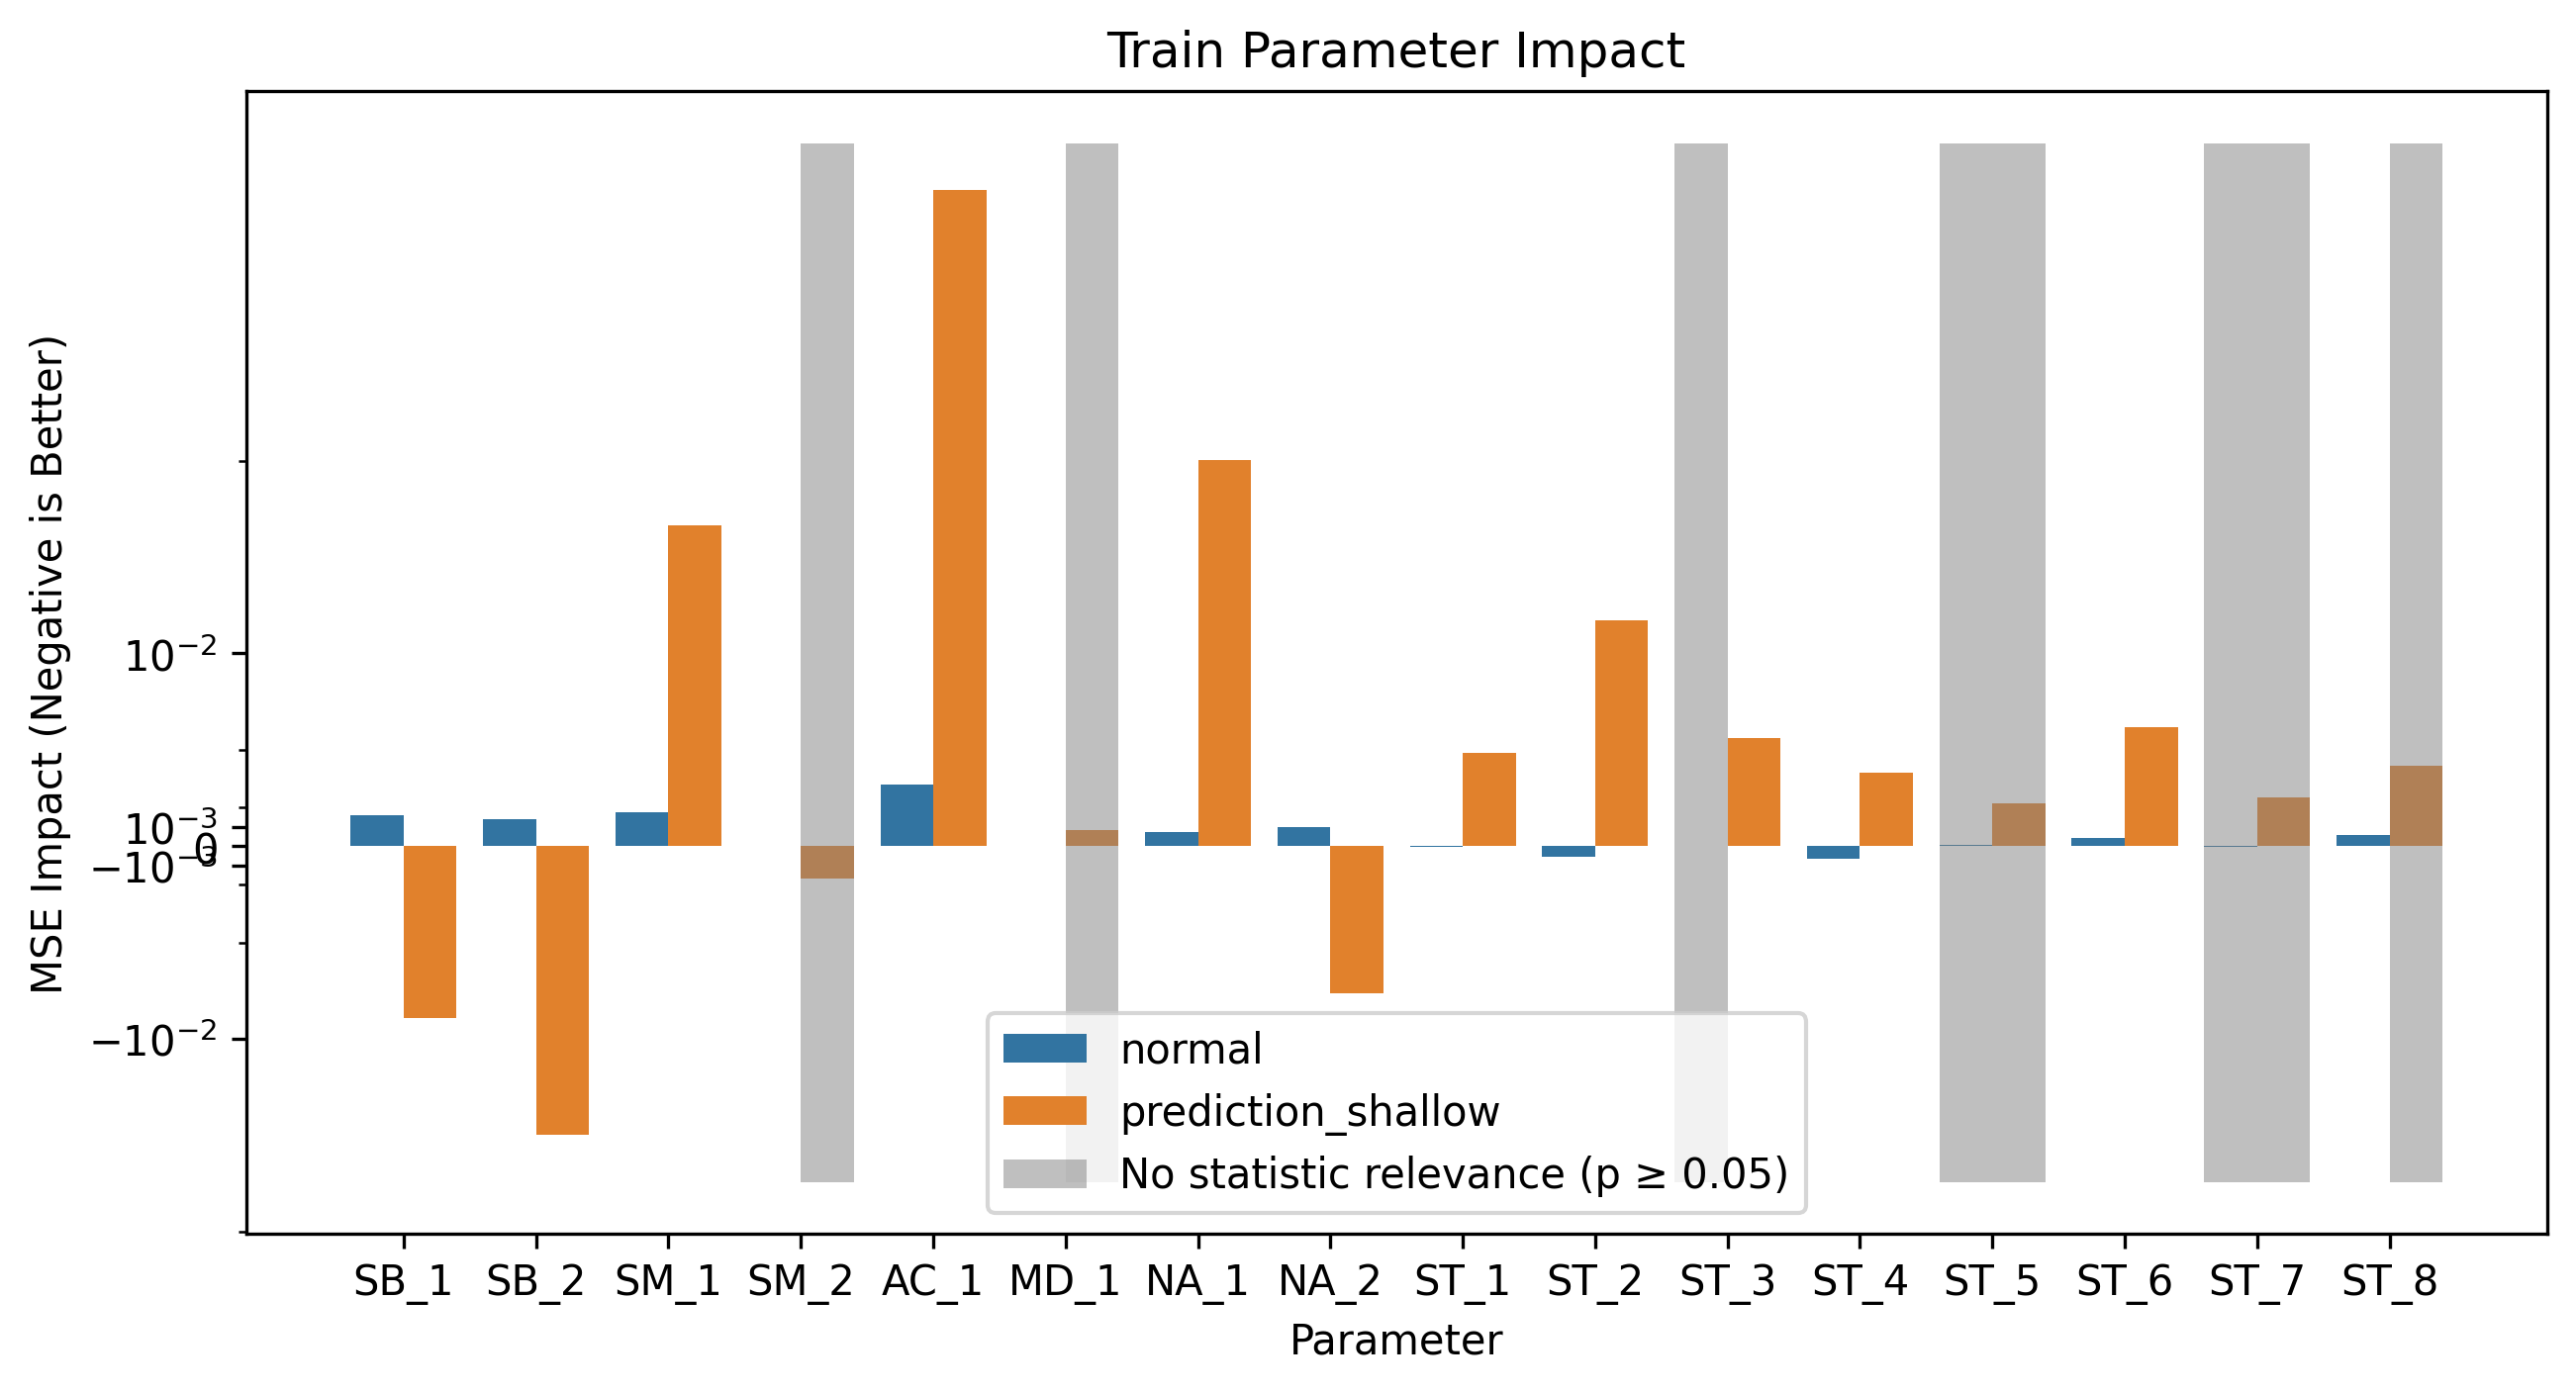

In [140]:
fig, ax = plt.subplots(dpi=300, figsize=(10, 5))
sns.barplot(df_test, x="variable", y="impact", hue="task", ax=ax)
plt.yscale("asinh")

y_lim = ax.get_ylim()

for i in range(len(failed)):
    variable = failed.iloc[i]["variable"]
    task = failed.iloc[i]["task"]

    index = variables.index(variable)

    if task == "normal":
        index -= 0.2
    else:
        index += 0.2


    label=None
    if i == 0:
        label = "No statistic relevance (p ≥ 0.05)"
    plt.bar([index, index],  y_lim, alpha=0.5, color="gray", width=0.4, label=label)

plt.title("Train Parameter Impact")
plt.ylabel("MSE Impact (Negative is Better)")
plt.xlabel("Parameter")
plt.legend()